In [5]:
# Check GPU
!nvidia-smi

# Basic installs (already in Colab usually)
!pip install -q tensorflow matplotlib seaborn opencv-python-headless


Sat Nov  8 19:55:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns, cv2, json, os

tf.random.set_seed(42)
np.random.seed(42)

# Output dirs
os.makedirs("models", exist_ok=True)


In [7]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

print("Train:", x_train.shape, "Test:", x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) Test: (10000, 28, 28)


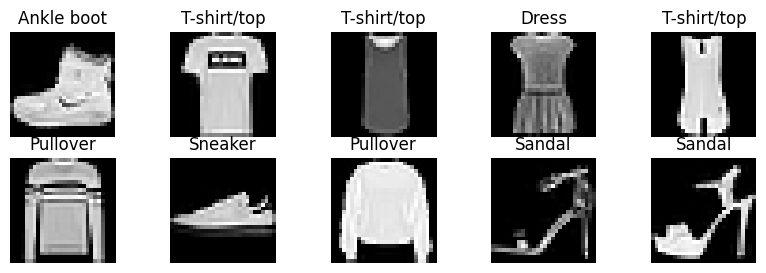

In [8]:
plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()


In [9]:
def preprocess(images):
    imgs = np.zeros((images.shape[0],32,32,1), dtype=np.float32)
    for i,img in enumerate(images):
        img = cv2.resize(img,(32,32))
        imgs[i,:,:,0] = img/255.0
    return imgs

x_train_p, x_test_p = preprocess(x_train), preprocess(x_test)
y_train_o, y_test_o = to_categorical(y_train,10), to_categorical(y_test,10)

print("Processed:", x_train_p.shape)


Processed: (60000, 32, 32, 1)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.08)
datagen.fit(x_train_p)


In [11]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,130 (1.36 MB)

 Trainable params: 356,682 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("models/best_model.h5", save_best_only=True)
]

history = model.fit(
    datagen.flow(x_train_p,y_train_o,batch_size=64),
    validation_data=(x_test_p,y_test_o),
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7345 - loss: 0.7409

938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.7346 - loss: 0.7407 - val_accuracy: 0.8448 - val_loss: 0.4174
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8380 - loss: 0.4306 - val_accuracy: 0.8344 - val_loss: 0.4459
Epoch 3/20
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8578 - loss: 0.3801

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8578 - loss: 0.3801 - val_accuracy: 0.8744 - val_loss: 0.3418
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8673 - loss: 0.3508 - val_accuracy: 0.8575 - val_loss: 0.3580
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8742 - loss: 0.3354 - val_accuracy: 0.8606 - val_loss: 0.3650
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8799 - loss: 0.3177 - val_accuracy: 0.8713 - val_loss: 0.3600
Epoch 7/20
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8831 - loss: 0.3128

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8831 - loss: 0.3128 - val_accuracy: 0.8866 - val_loss: 0.3080
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8855 - loss: 0.3040

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8855 - loss: 0.3040 - val_accuracy: 0.9007 - val_loss: 0.2705
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8874 - loss: 0.2983 - val_accuracy: 0.8554 - val_loss: 0.4392
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8928 - loss: 0.2885 - val_accuracy: 0.8990 - val_loss: 0.2748
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8955 - loss: 0.2753 - val_accuracy: 0.8985 - val_loss: 0.2736
Epoch 12/20
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8950 - loss: 0.2791

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8950 - loss: 0.2791 - val_accuracy: 0.9024 - val_loss: 0.2629
Epoch 13/20
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8967 - loss: 0.2721

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8968 - loss: 0.2721 - val_accuracy: 0.9095 - val_loss: 0.2521
Epoch 14/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9021 - loss: 0.2619 - val_accuracy: 0.8989 - val_loss: 0.2780
Epoch 15/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9034 - loss: 0.2629 - val_accuracy: 0.8925 - val_loss: 0.2850
Epoch 16/20
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9022 - loss: 0.2580

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9022 - loss: 0.2580 - val_accuracy: 0.9135 - val_loss: 0.2397
Epoch 17/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9063 - loss: 0.2504 - val_accuracy: 0.8865 - val_loss: 0.3043
Epoch 18/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9062 - loss: 0.2469 - val_accuracy: 0.8831 - val_loss: 0.3465
Epoch 19/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9086 - loss: 0.2443 - val_accuracy: 0.8908 - val_loss: 0.2926
Epoch 20/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9088 - loss: 0.2449 - val_accuracy: 0.9026 - val_loss: 0.2704


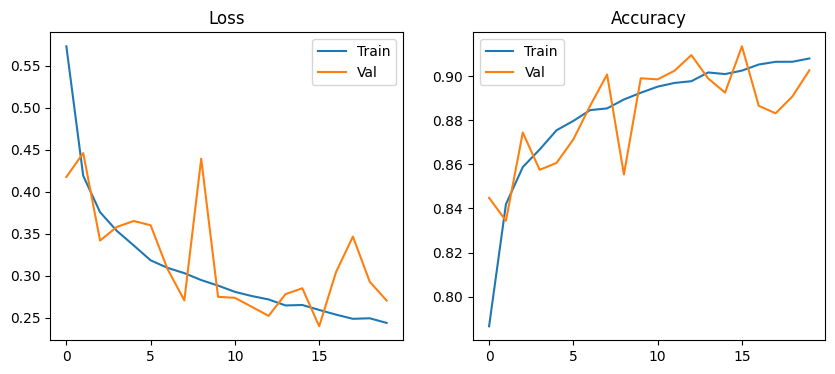

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train'); plt.plot(history.history['val_loss'],label='Val'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Train'); plt.plot(history.history['val_accuracy'],label='Val'); plt.title('Accuracy'); plt.legend()
plt.show()


In [14]:
test_loss, test_acc = model.evaluate(x_test_p,y_test_o,verbose=0)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


✅ Test Accuracy: 91.35%


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


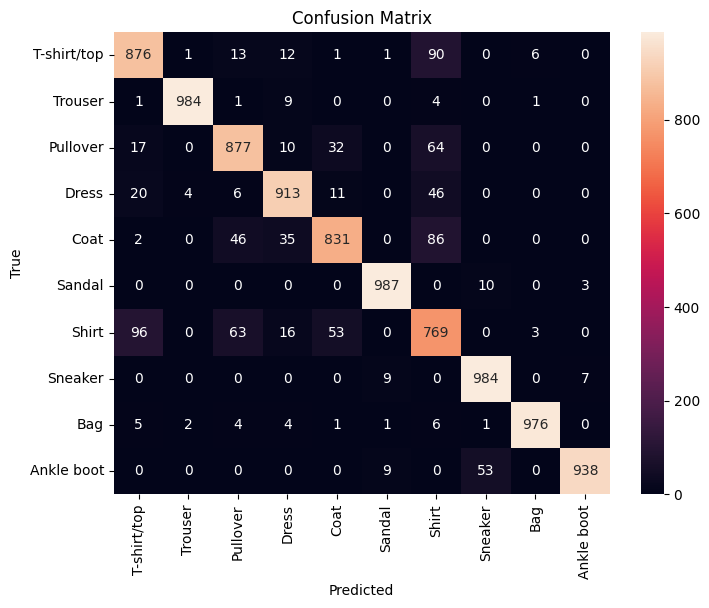

In [15]:
y_pred = np.argmax(model.predict(x_test_p),axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


In [16]:
model.save("models/AI_Closet_CNN.h5")
with open("models/meta.json","w") as f:
    json.dump({"class_names":class_names},f)
print("Model + metadata saved ✅")


Model + metadata saved ✅


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: Trouser
Material: Denim
Impact: Medium
Suggestion: Repair / Reuse


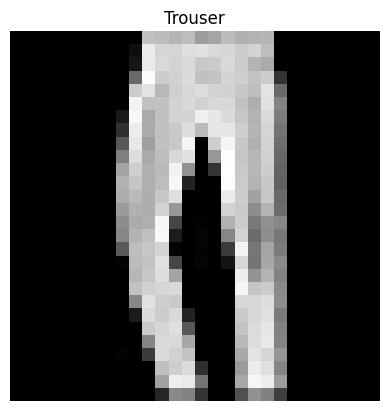

In [18]:
SUSTAINABILITY_MAP = {
 'T-shirt/top': {'material':'Cotton','impact':'Low','suggestion':'Reuse / Donate'},
 'Trouser': {'material':'Denim','impact':'Medium','suggestion':'Repair / Reuse'},
 'Pullover': {'material':'Wool','impact':'Medium','suggestion':'Repair / Upcycle'},
 'Dress': {'material':'Synthetic blend','impact':'High','suggestion':'Recycle / Donate'},
 'Coat': {'material':'Polyester','impact':'High','suggestion':'Recycle'},
 'Sandal': {'material':'Rubber','impact':'High','suggestion':'Reuse / Repair'},
 'Shirt': {'material':'Cotton','impact':'Low','suggestion':'Donate / Reuse'},
 'Sneaker': {'material':'Synthetic','impact':'High','suggestion':'Repair / Recycle'},
 'Bag': {'material':'PU Leather','impact':'High','suggestion':'Repurpose / Recycle'},
 'Ankle boot': {'material':'Leather','impact':'High','suggestion':'Repair / Resell'}
}

def predict_and_suggest(index=0):
    img = x_test[index]
    proc = preprocess(np.array([img]))
    preds = model.predict(proc)
    cls = np.argmax(preds)
    label = class_names[cls]
    info = SUSTAINABILITY_MAP[label]
    print(f"Predicted: {label}\nMaterial: {info['material']}\nImpact: {info['impact']}\nSuggestion: {info['suggestion']}")
    plt.imshow(img,cmap='gray'); plt.axis('off'); plt.title(label); plt.show()

predict_and_suggest(5)
